# Step 1: Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install openpyxl
#!pip install --upgrade pip

# Step 2: Loading Data

In [ ]:
# Load the Accessories sheet from the Excel file
outdoor_data = pd.read_excel('Outdoor.xlsx', sheet_name="Outdoor")

# Display the first few rows to inspect the data
outdoor_data.head()

In [10]:
data=outdoor_data.copy()

In [11]:
#Step 1: showing qantity of rows and columns of data
print(f"\033[1m\nThere are {data.shape[0]} rows and {data.shape[1]} columns in the data\033[0m")

#Step 2: define function to inspect data types and nulls
def inspect(df):
    column_summary = []
    for col in df.columns:
        column_info = {
            "Column": col,
            "Data Type": df[col].dtype,
            "Unique Values": df[col].nunique(),
        }
        column_summary.append(column_info)
    
    return pd.DataFrame(column_summary)
inspect(data)


There are 335740 rows and 17 columns in the data


,Column,Data Type,Unique Values
0,Customer Name,object,4573
1,Reporting Business Type,object,3
2,Collective Class,object,1
3,Series No,object,235
4,Item SKU,object,699
5,Item Description,object,123
6,Colors,object,58
7,Series Color,object,40
8,Item Grouping,object,4
9,AFI Sales Category,object,2


# Step 3: Check missing

In [12]:
import pandas as pd

# -------------------------------
# Step 1: Create a Year-Month Column
# -------------------------------
# Extract Year-Month as a Period (ignoring day) from FiscalMonthLastDate.
data['YearMonth'] = data['FiscalMonthLastDate'].dt.to_period('M')

# -------------------------------
# Step 2: Aggregate Data by Series and Month
# -------------------------------
# We want to combine all SKUs within a series for the same month.
# For "Order Quantity" we sum the values.
# For the remaining attributes, we assume they are constant for a series and take the first non-null value.
# Create an aggregation dictionary.
agg_dict = {}
for col in data.columns:
    if col in ['Series No', 'YearMonth']:
        # These columns will be used as grouping keys.
        continue
    elif col == 'Order Quantity':
        agg_dict[col] = 'sum'
    else:
        # For all other columns, take the first value (assuming consistency within a series)
        agg_dict[col] = 'first'

# Group by Series No and YearMonth and aggregate.
aggregated_data = data.groupby(['Series No', 'YearMonth'], as_index=False).agg(agg_dict)

# -------------------------------
# Step 3: Identify the Date Ranges per Series
# -------------------------------
series_date_ranges = aggregated_data.groupby('Series No')['YearMonth'].agg(['min', 'max']).reset_index()

# (Optional) Determine missing months per series for analysis.
missing_periods_adjusted = {}
for _, row in series_date_ranges.iterrows():
    series = row['Series No']
    start_period = row['min']
    end_period = row['max']
    expected_periods = pd.period_range(start=start_period, end=end_period, freq='M')
    actual_periods = set(aggregated_data[aggregated_data['Series No'] == series]['YearMonth'].unique())
    missing_periods = set(expected_periods) - actual_periods
    if missing_periods:
        missing_periods_adjusted[series] = sorted(missing_periods)

missing_periods_df_adjusted = pd.DataFrame(
    [(series, period) for series, periods in missing_periods_adjusted.items() for period in periods],
    columns=['Series No', 'Missing Year-Month']
)

print("Missing Year-Month Analysis for Each Series:")
print(missing_periods_df_adjusted)

# -------------------------------
# Step 4: Fill Missing Months While Preserving All Attributes
# -------------------------------
# For each series, we generate the complete range of months between the first and last observed months.
# Then we merge the aggregated data with this complete set. 
# For "Order Quantity", missing months get a 0.
# For the other columns, we fill missing values with the first non-null value from the series.
cleaned_data = pd.DataFrame()

for _, row in series_date_ranges.iterrows():
    series = row['Series No']
    start_period = row['min']
    end_period = row['max']
    
    # Generate expected monthly periods for the series.
    expected_periods = pd.DataFrame({'YearMonth': pd.period_range(start=start_period, end=end_period, freq='M')})
    expected_periods['Series No'] = series
    
    # Get the aggregated data for this series.
    series_data = aggregated_data[aggregated_data['Series No'] == series]
    
    # Merge the expected periods with the aggregated data.
    merged_data = expected_periods.merge(series_data, on=['Series No', 'YearMonth'], how='left')
    
    # Fill missing Order Quantity with 0 (assuming no sales occurred in the missing months)
    merged_data['Order Quantity'] = merged_data['Order Quantity'].fillna(0)
    
    # For all other attributes, if data is missing, fill it with the first non-null value from series_data.
    for col in merged_data.columns:
        if col not in ['Series No', 'YearMonth', 'Order Quantity']:
            if merged_data[col].isnull().all():
                continue  # If all values are missing, we leave it as is.
            else:
                first_val = series_data[col].dropna().iloc[0]
                merged_data[col] = merged_data[col].fillna(first_val)
    
    # Append the merged data for this series.
    cleaned_data = pd.concat([cleaned_data, merged_data], ignore_index=True)

# -------------------------------
# Step 5: Optional Filtering
# -------------------------------
# Drop series with more than 50% zero sales months (if that is part of your criteria).
series_missing_count = cleaned_data.groupby('Series No')['Order Quantity'].apply(lambda x: (x == 0).sum())
series_total_months = cleaned_data.groupby('Series No')['Order Quantity'].count()
series_missing_ratio = series_missing_count / series_total_months

valid_series = series_missing_ratio[series_missing_ratio <= 0.5].index
cleaned_data = cleaned_data[cleaned_data['Series No'].isin(valid_series)].reset_index(drop=True)

print("Cleaned Outdoor Data (first few rows):")
print(cleaned_data.head())

# -------------------------------
# Step 6: Save the Cleaned Data
# -------------------------------
cleaned_data.to_csv("Cleaned_Outdoor_Data.csv", index=False)
print("File Saved: Cleaned_Outdoor_Data.csv")


Missing Year-Month Analysis for Each Series:
     Series No Missing Year-Month
0         P008            2023-03
1         P008            2023-06
2     P008-813            2023-03
3     P008-813            2023-06
4     P008-813            2023-10
...        ...                ...
1110     PA804            2023-06
1111     PA804            2023-08
1112     PA804            2023-11
1113     PA804            2024-01
1114     PA804            2024-07

[1115 rows x 2 columns]
Cleaned Outdoor Data (first few rows):
  YearMonth Series No   Customer Name Reporting Business Type  \
0   2022-01      P000    Customer 765                      US   
1   2022-02      P000    Customer 419                      US   
2   2022-03      P000    Customer 217                      US   
3   2023-02      P008  Customer 17910                      US   
4   2023-03      P008  Customer 17910                      US   

  Collective Class  Item SKU           Item Description Colors Series Color  \
0          OU

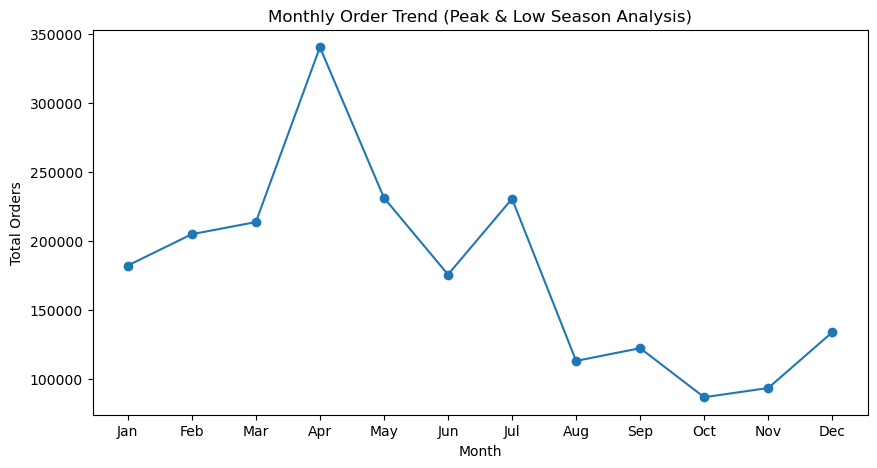

In [13]:
import matplotlib.pyplot as plt

# Convert 'YearMonth' to datetime if not already
cleaned_data['YearMonth'] = pd.to_datetime(cleaned_data['YearMonth'].astype(str))

# Group data by month to check seasonality
seasonality_trend = cleaned_data.groupby(cleaned_data['YearMonth'].dt.month)['Order Quantity'].sum()

# Plot seasonality pattern
plt.figure(figsize=(10, 5))
plt.plot(seasonality_trend.index, seasonality_trend.values, marker='o', linestyle='-')
plt.xlabel("Month")
plt.ylabel("Total Orders")
plt.title("Monthly Order Trend (Peak & Low Season Analysis)")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

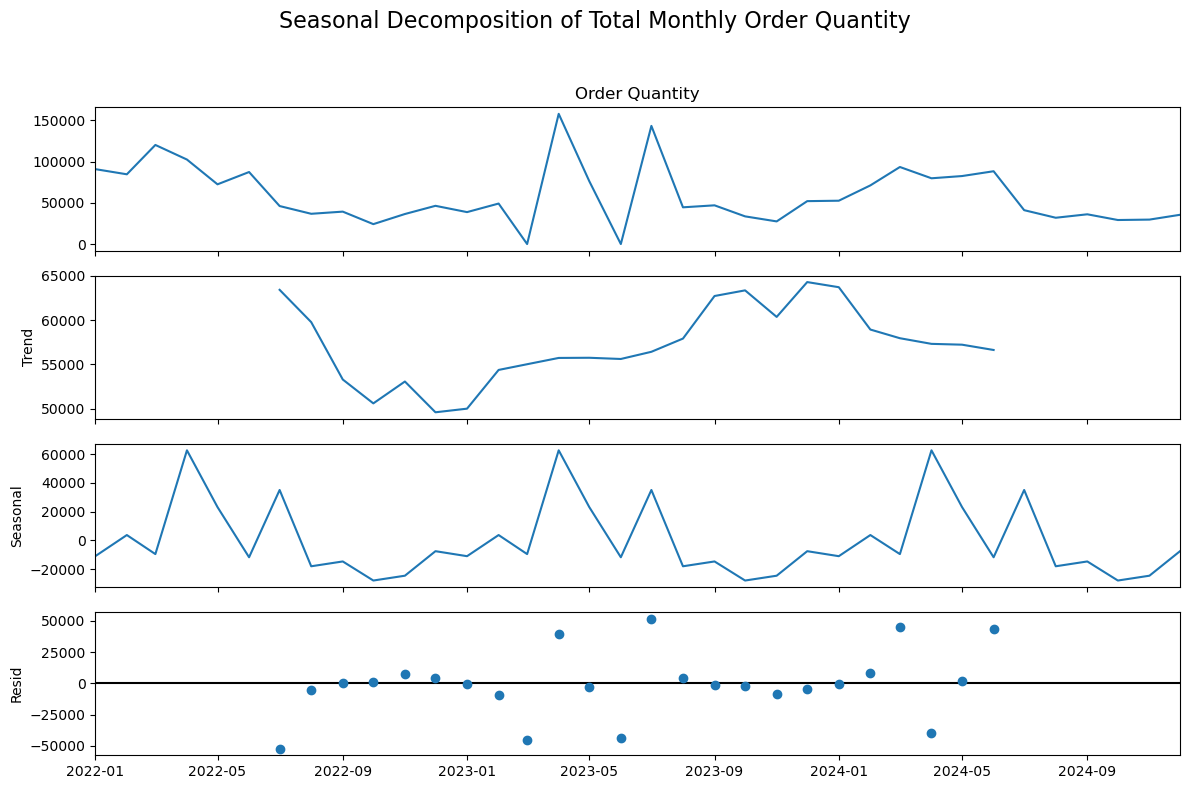

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose

# -----------------------------------------------------------
# Step 1: Load Data and Aggregate to Total Level
# -----------------------------------------------------------
# Make sure "Cleaned_Outdoor_Data.csv" is in your working directory.
data = pd.read_csv("Cleaned_Outdoor_Data.csv")
# Convert the YearMonth column to datetime (assuming it already exists)
data['YearMonth'] = pd.to_datetime(data['YearMonth'].astype(str))

# Aggregate the data: sum the "Order Quantity" for each month
total_data = data.groupby('YearMonth')['Order Quantity'].sum().reset_index()
total_data = total_data.sort_values('YearMonth')
total_data.set_index('YearMonth', inplace=True)

# -----------------------------------------------------------
# Step 2: Perform Seasonal Decomposition
# -----------------------------------------------------------
# For monthly data, set the period to 12. You can choose an additive or multiplicative model.
decomposition = seasonal_decompose(total_data['Order Quantity'], model='additive', period=12)

# -----------------------------------------------------------
# Step 3: Plot the Decomposition
# -----------------------------------------------------------
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Seasonal Decomposition of Total Monthly Order Quantity", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Step 4: Model

In [14]:
# Step 0: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For time series modeling:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For automatic SARIMA parameter selection:
# If not installed, uncomment the next two lines:
#!pip install pmdarima
import pmdarima as pm


# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# For error calculation
from sklearn.metrics import mean_absolute_percentage_error

# Manual model on total Grouping

In [2]:
import pandas as pd
import warnings
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore")

# Load the cleaned data (make sure "Cleaned_Outdoor_Data.csv" is in your working directory)
data = pd.read_csv("Cleaned_Outdoor_Data.csv")
data['YearMonth'] = pd.to_datetime(data['YearMonth'].astype(str))

# Aggregate to Total Level: sum the "Order Quantity" over all records per month.
total_data = data.groupby('YearMonth')['Order Quantity'].sum().reset_index()
total_data = total_data.sort_values('YearMonth')
total_data.set_index('YearMonth', inplace=True)

# Run the Augmented Dickey-Fuller test
result = adfuller(total_data['Order Quantity'])
print("ADF Statistic: {:.4f}".format(result[0]))
print("p-value: {:.4f}".format(result[1]))
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")

# Instructions:
# If the p-value is less than 0.05, the series is likely stationary (so d = 0).
# If the p-value is greater than 0.05, the series is non-stationary and you might set d = 1.,

ADF Statistic: -4.6339
p-value: 0.0001
Critical Values:
   1%: -3.6699
   5%: -2.9641
   10%: -2.6212


Plotting ACF and PACF for the original series using 12 lags.


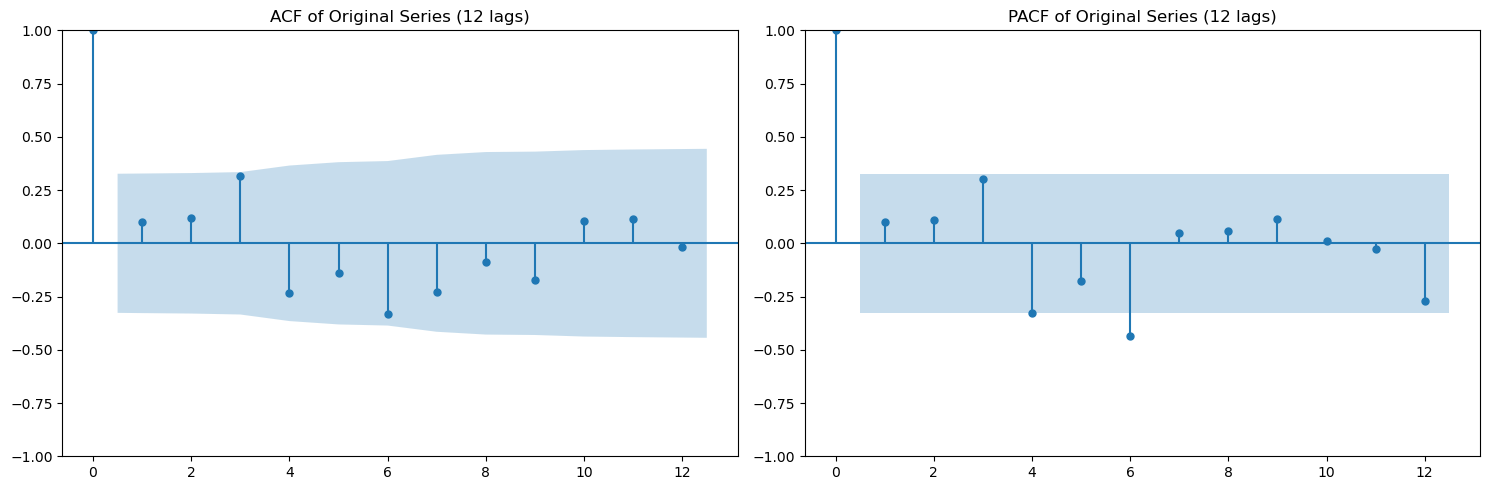

Enter the non-seasonal order (p,d,q) [e.g., '1,1,1' if d=1 is needed]: 2,1,0
Selected non-seasonal order: (2, 1, 0)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore")

# Load and aggregate the data
data = pd.read_csv("Cleaned_Outdoor_Data.csv")
data['YearMonth'] = pd.to_datetime(data['YearMonth'].astype(str))
total_data = data.groupby('YearMonth')['Order Quantity'].sum().reset_index()
total_data = total_data.sort_values('YearMonth')
total_data.set_index('YearMonth', inplace=True)

# Plot ACF and PACF of the ORIGINAL series using fixed 12 lags.
print("Plotting ACF and PACF for the original series using 12 lags.")
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(total_data['Order Quantity'], lags=12, ax=axes[0])
axes[0].set_title("ACF of Original Series (12 lags)")
plot_pacf(total_data['Order Quantity'], lags=12, ax=axes[1])
axes[1].set_title("PACF of Original Series (12 lags)")
plt.tight_layout()
plt.show()

# Instructions:
# - Inspect the PACF plot: a sharp cutoff after lag p may indicate the number of AR terms.
# - Inspect the ACF plot: a sharp cutoff after lag q may indicate the number of MA terms.
order_str = input("Enter the non-seasonal order (p,d,q) [e.g., '1,1,1' if d=1 is needed]: ")
if order_str.strip() == "":
    non_seasonal_order = (1, 1, 1)  # Default value
else:
    non_seasonal_order = tuple(int(x.strip()) for x in order_str.split(","))
print("Selected non-seasonal order:", non_seasonal_order)

Using 11 lags instead of 12 due to sample size restrictions.
Plotting ACF and PACF for the seasonally differenced series using 11 lags.


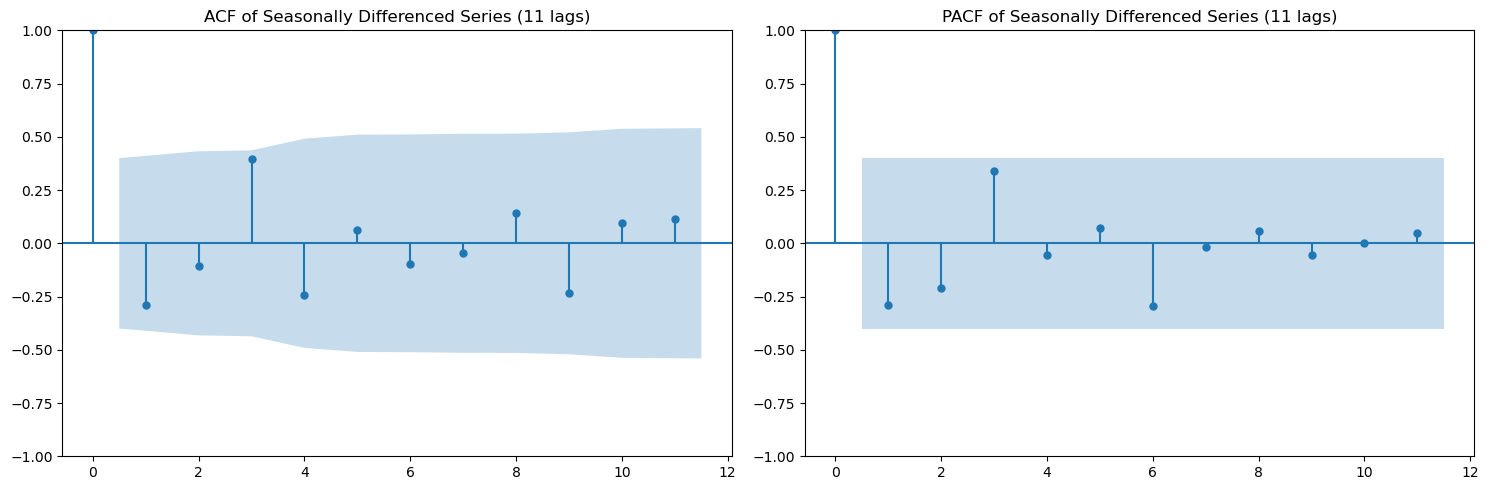

Enter the seasonal order (P,D,Q,s) [default is '1,1,1,12']: 1,1,0,12
Selected seasonal order: (1, 1, 0, 12)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore")

# Load and aggregate the data (same as before)
data = pd.read_csv("Cleaned_Outdoor_Data.csv")
data['YearMonth'] = pd.to_datetime(data['YearMonth'].astype(str))
total_data = data.groupby('YearMonth')['Order Quantity'].sum().reset_index()
total_data = total_data.sort_values('YearMonth')
total_data.set_index('YearMonth', inplace=True)

# Compute seasonal differencing (lag = 12) to isolate the seasonal component.
seasonal_diff = total_data['Order Quantity'].diff(12).dropna()
n_seasonal = len(seasonal_diff)

# We want to use 12 lags. However, the PACF function requires that the number of lags be less than half the sample size.
# Compute the maximum allowed lags:
allowed_max = (n_seasonal // 2) - 1

# Set desired lags to 12, but if that's too high, use the allowed maximum.
desired_lags = 12
if desired_lags >= allowed_max:
    print(f"Warning: The seasonally differenced series has only {n_seasonal} observations.")
    print(f"Using {allowed_max} lags instead of {desired_lags} due to sample size restrictions.")
    max_lags_seasonal = allowed_max
else:
    max_lags_seasonal = desired_lags

print(f"Plotting ACF and PACF for the seasonally differenced series using {max_lags_seasonal} lags.")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(seasonal_diff, lags=max_lags_seasonal, ax=axes[0])
axes[0].set_title(f"ACF of Seasonally Differenced Series ({max_lags_seasonal} lags)")
plot_pacf(seasonal_diff, lags=max_lags_seasonal, ax=axes[1])
axes[1].set_title(f"PACF of Seasonally Differenced Series ({max_lags_seasonal} lags)")
plt.tight_layout()
plt.show()

# Prompt the user to set the seasonal order based on the plots.
seasonal_order_str = input("Enter the seasonal order (P,D,Q,s) [default is '1,1,1,12']: ")
if seasonal_order_str.strip() == "":
    seasonal_order = (1, 1, 1, 12)  # Default value
else:
    seasonal_order = tuple(int(x.strip()) for x in seasonal_order_str.split(","))
print("Selected seasonal order:", seasonal_order)

In [5]:
import pandas as pd
import warnings
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

warnings.filterwarnings("ignore")

# Load the cleaned data (if not already loaded)
data = pd.read_csv("Cleaned_Outdoor_Data.csv")
data['YearMonth'] = pd.to_datetime(data['YearMonth'].astype(str))

# Aggregate to Total Level
total_data = data.groupby('YearMonth')['Order Quantity'].sum().reset_index()
total_data = total_data.sort_values('YearMonth')
total_data.set_index('YearMonth', inplace=True)

# Split the data into 80% training and 20% testing.
n = len(total_data)
train_size = int(0.8 * n)
train = total_data.iloc[:train_size]
test = total_data.iloc[train_size:]

# IMPORTANT:
# The variables 'non_seasonal_order' and 'seasonal_order' should have been set in Code Blocks 2 and 3.
print("Fitting SARIMA model with non-seasonal order:", non_seasonal_order, "and seasonal order:", seasonal_order)

model = SARIMAX(train['Order Quantity'],
                order=non_seasonal_order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=False)

forecast = model_fit.get_forecast(steps=len(test)).predicted_mean
mape_val = mean_absolute_percentage_error(test['Order Quantity'], forecast)
print("MAPE on the test set: {:.2f}%".format(mape_val * 100))


Fitting SARIMA model with non-seasonal order: (2, 1, 0) and seasonal order: (1, 1, 0, 12)
MAPE on the test set: 37.43%


## Auto arima

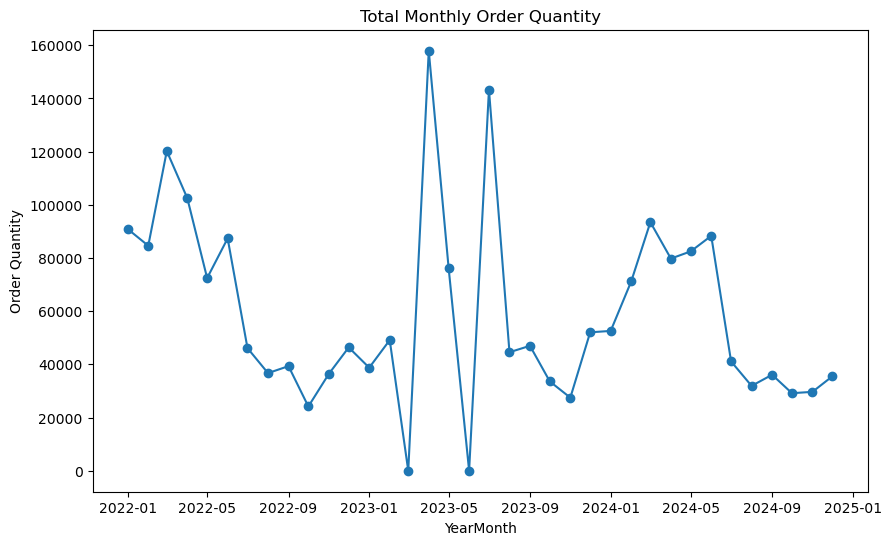

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=391.053, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=384.945, Time=0.05 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=385.644, Time=0.16 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=387.128, Time=1.18 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=385.536, Time=0.12 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=387.257, Time=0.30 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=389.026, Time=1.46 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=387.537, Time=0.36 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=389.257, Time=0.44 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=391.026, Time=1.59 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=inf, Time=1.41 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=389.536, Time=1.46 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=391.257, Time=2.53 sec
 ARIMA(0,1,1)(0,1,0)[1

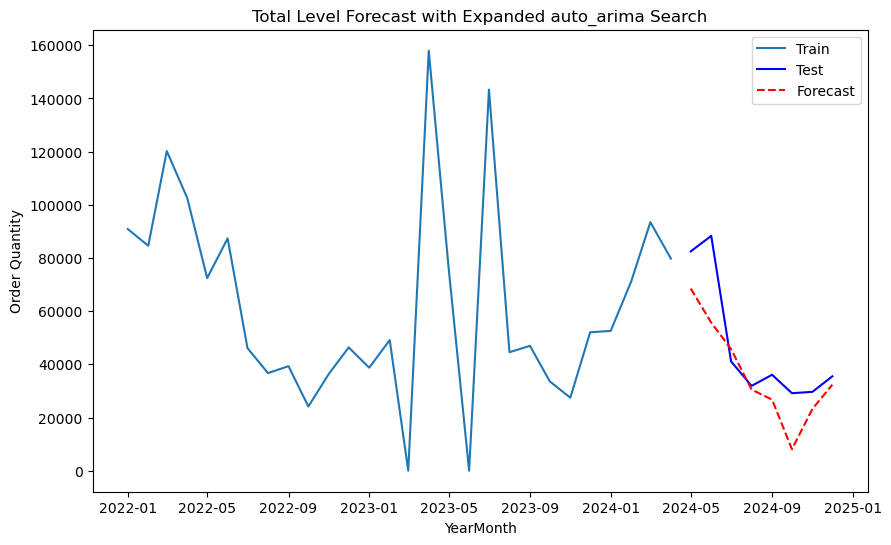

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

# -----------------------------------------------------------
# Step 1: Load and Aggregate Data to the Total Level
# -----------------------------------------------------------
# Ensure that "Cleaned_Outdoor_Data.csv" is in your working directory.
data = pd.read_csv("Cleaned_Outdoor_Data.csv")
data['YearMonth'] = pd.to_datetime(data['YearMonth'].astype(str))

# Aggregate: Sum the "Order Quantity" over all records for each month.
total_data = data.groupby('YearMonth')['Order Quantity'].sum().reset_index()
total_data = total_data.sort_values('YearMonth')
total_data.set_index('YearMonth', inplace=True)

# Optional: Plot the total series to inspect its behavior.
plt.figure(figsize=(10, 6))
plt.plot(total_data.index, total_data['Order Quantity'], marker='o')
plt.title("Total Monthly Order Quantity")
plt.xlabel("YearMonth")
plt.ylabel("Order Quantity")
plt.show()

# -----------------------------------------------------------
# Step 2: Split Data into Training (80%) and Testing (20%)
# -----------------------------------------------------------
n = len(total_data)
train_size = int(0.8 * n)
train = total_data.iloc[:train_size]
test  = total_data.iloc[train_size:]

# -----------------------------------------------------------
# Step 3: Use Auto ARIMA with an Expanded Search Grid (Non-Stepwise)
# -----------------------------------------------------------
# Here we force non-seasonal differencing d=1 and seasonal differencing D=1.
# We also expand the search grid for AR and MA terms (p, q, P, Q) and turn off stepwise search.
# This may help auto_arima find a better model.
auto_model_expanded = pm.auto_arima(
    train['Order Quantity'],
    seasonal=True,
    m=12,                # monthly seasonality
    d=1,                 # force one non-seasonal difference
    D=1,                 # force one seasonal difference
    max_d=1,
    max_D=1,
    start_p=1,
    start_q=1,
    start_P=1,
    start_Q=1,
    max_p=5,             # allow higher p
    max_q=5,             # allow higher q
    max_P=3,             # allow higher seasonal AR terms
    max_Q=3,             # allow higher seasonal MA terms
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=False      # non-stepwise search (more exhaustive)
)

order_expanded = auto_model_expanded.order
seasonal_order_expanded = auto_model_expanded.seasonal_order
print("Expanded search selected non-seasonal order:", order_expanded)
print("Expanded search selected seasonal order:", seasonal_order_expanded)

# -----------------------------------------------------------
# Step 4: Forecast and Evaluate
# -----------------------------------------------------------
forecast_expanded = auto_model_expanded.predict(n_periods=len(test))
mape_expanded = mean_absolute_percentage_error(test['Order Quantity'], forecast_expanded)
print("MAPE on the test set (expanded search): {:.2f}%".format(mape_expanded * 100))

# -----------------------------------------------------------
# (Optional) Step 5: Plot the Forecast Against the Actual Data
# -----------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Order Quantity'], label="Train")
plt.plot(test.index, test['Order Quantity'], label="Test", color='blue')
plt.plot(test.index, forecast_expanded, label="Forecast", color='red', linestyle='--')
plt.legend()
plt.title("Total Level Forecast with Expanded auto_arima Search")
plt.xlabel("YearMonth")
plt.ylabel("Order Quantity")
plt.show()


# Model on items

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error

# -----------------------------------------------------------
# Step 1: Load Data and Aggregate by Item Grouping and Month
# -----------------------------------------------------------
data = pd.read_csv("Cleaned_Outdoor_Data.csv")
data['YearMonth'] = pd.to_datetime(data['YearMonth'].astype(str))

# Aggregate: For each Item Grouping and YearMonth, sum the Order Quantity.
grouping_data = data.groupby(['Item Grouping', 'YearMonth'])['Order Quantity'].sum().reset_index()
grouping_data = grouping_data.sort_values(['Item Grouping', 'YearMonth'])

# -----------------------------------------------------------
# Step 2: Loop Over Each Item Grouping and Try Two Approaches
# -----------------------------------------------------------
results = []  # To store best MAPE and selected approach for each group

# List of unique item groupings
item_groups = grouping_data['Item Grouping'].unique()

print("Starting forecasting for each Item Grouping (trying both raw and log-transformed models)...\n")

for idx, group in enumerate(item_groups, start=1):
    # Subset data for this group
    group_df = grouping_data[grouping_data['Item Grouping'] == group].copy()
    group_df['YearMonth'] = pd.to_datetime(group_df['YearMonth'])
    group_df = group_df.sort_values('YearMonth')
    group_df.set_index('YearMonth', inplace=True)
    
    # Require at least 24 months of data
    if len(group_df) < 24:
        print(f"[{idx}/{len(item_groups)}] Skipping '{group}' (only {len(group_df)} months available)")
        continue

    # Split into 80% train and 20% test
    n = len(group_df)
    train_size = int(0.8 * n)
    train = group_df.iloc[:train_size]
    test  = group_df.iloc[train_size:]
    
    # Prepare a dictionary to hold results for both approaches
    model_results = {}
    
    # -----------------------------
    # Approach 1: Raw Data Modeling
    # -----------------------------
    try:
        auto_model_raw = pm.auto_arima(
            train['Order Quantity'],
            seasonal=True,
            m=12,
            d=1,                 # force one non-seasonal difference
            D=1,                 # force one seasonal difference
            max_d=1,
            max_D=1,
            start_p=1,
            start_q=1,
            start_P=1,
            start_Q=1,
            max_p=5,
            max_q=5,
            max_P=3,
            max_Q=3,
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=False
        )
        forecast_raw = auto_model_raw.predict(n_periods=len(test))
        mape_raw = mean_absolute_percentage_error(test['Order Quantity'], forecast_raw)
        model_results['raw'] = {
            'MAPE': mape_raw,
            'order': auto_model_raw.order,
            'seasonal_order': auto_model_raw.seasonal_order,
            'forecast': forecast_raw
        }
    except Exception as e:
        print(f"Error with raw model for '{group}': {e}")
        model_results['raw'] = None

    # -----------------------------------
    # Approach 2: Log-Transformed Modeling
    # -----------------------------------
    try:
        # Use log(x+1) transformation to avoid issues with zeros
        train_log = np.log(train['Order Quantity'] + 1)
        test_log = np.log(test['Order Quantity'] + 1)
        auto_model_log = pm.auto_arima(
            train_log,
            seasonal=True,
            m=12,
            d=1,
            D=1,
            max_d=1,
            max_D=1,
            start_p=1,
            start_q=1,
            start_P=1,
            start_Q=1,
            max_p=5,
            max_q=5,
            max_P=3,
            max_Q=3,
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=False
        )
        forecast_log = auto_model_log.predict(n_periods=len(test))
        # Back-transform forecast: inverse of log(x+1) is exp(x) - 1
        forecast_log_back = np.exp(forecast_log) - 1
        mape_log = mean_absolute_percentage_error(test['Order Quantity'], forecast_log_back)
        model_results['log'] = {
            'MAPE': mape_log,
            'order': auto_model_log.order,
            'seasonal_order': auto_model_log.seasonal_order,
            'forecast': forecast_log_back
        }
    except Exception as e:
        print(f"Error with log model for '{group}': {e}")
        model_results['log'] = None

    # Decide which approach is better based on MAPE
    best_approach = None
    if model_results['raw'] is not None and model_results['log'] is not None:
        if model_results['raw']['MAPE'] <= model_results['log']['MAPE']:
            best_approach = 'raw'
        else:
            best_approach = 'log'
    elif model_results['raw'] is not None:
        best_approach = 'raw'
    elif model_results['log'] is not None:
        best_approach = 'log'
    else:
        print(f"Both modeling approaches failed for '{group}'")
        continue

    best_mape = model_results[best_approach]['MAPE']
    best_order = model_results[best_approach]['order']
    best_seasonal_order = model_results[best_approach]['seasonal_order']
    
    print(f"[{idx}/{len(item_groups)}] '{group}' - Best approach: {best_approach.upper()} | MAPE: {best_mape*100:.2f}%")
    print(f"    Orders: {best_order} ; Seasonal Orders: {best_seasonal_order}\n")
    
    results.append({
        'Item Grouping': group,
        'Best Approach': best_approach,
        'MAPE': best_mape,
        'Order': best_order,
        'Seasonal Order': best_seasonal_order
    })

# -----------------------------------------------------------
# Step 3: Display and Save the Forecasting Results
# -----------------------------------------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='MAPE')
print("\nFinal Forecasting Results by Item Grouping:")
print(results_df)

# Optionally, save results to CSV for further analysis.
results_df.to_csv("Item_Grouping_Forecast_Results_FineTuned.csv", index=False)
print("\nResults saved to 'Item_Grouping_Forecast_Results_FineTuned.csv'")


Starting forecasting for each Item Grouping (trying both raw and log-transformed models)...

[1/4] 'Outdoor Accessories' - Best approach: LOG | MAPE: 37.05%
    Orders: (0, 1, 1) ; Seasonal Orders: (1, 1, 0, 12)

[2/4] 'Outdoor Dining' - Best approach: LOG | MAPE: 20.98%
    Orders: (0, 1, 1) ; Seasonal Orders: (1, 1, 0, 12)

[3/4] 'Outdoor Fire Pit Chat' - Best approach: LOG | MAPE: 815.17%
    Orders: (2, 1, 1) ; Seasonal Orders: (1, 1, 0, 12)

[4/4] 'Outdoor Seating' - Best approach: LOG | MAPE: 28.71%
    Orders: (0, 1, 1) ; Seasonal Orders: (1, 1, 0, 12)


Final Forecasting Results by Item Grouping:
           Item Grouping Best Approach      MAPE      Order Seasonal Order
1         Outdoor Dining           log  0.209837  (0, 1, 1)  (1, 1, 0, 12)
3        Outdoor Seating           log  0.287070  (0, 1, 1)  (1, 1, 0, 12)
0    Outdoor Accessories           log  0.370480  (0, 1, 1)  (1, 1, 0, 12)
2  Outdoor Fire Pit Chat           log  8.151717  (2, 1, 1)  (1, 1, 0, 12)

Results save

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error

# If you want holidays exogenous, uncomment these lines:
# import holidays
# us_holidays = holidays.UnitedStates()

# =============================================================================
# 1) Load Data and Aggregate by Item Grouping
# =============================================================================
data = pd.read_csv("Cleaned_Outdoor_Data.csv")
data['YearMonth'] = pd.to_datetime(data['YearMonth'].astype(str))

grouping_data = (
    data.groupby(['Item Grouping', 'YearMonth'], as_index=False)['Order Quantity']
        .sum()
        .sort_values(['Item Grouping', 'YearMonth'])
)

# =============================================================================
# 2) (Optional) Remove or Winsorize Outliers
# =============================================================================
def remove_outliers_winsor(df, col, lower_q=0.01, upper_q=0.99):
    q_low = df[col].quantile(lower_q)
    q_high = df[col].quantile(upper_q)
    df[col] = df[col].clip(lower=q_low, upper=q_high)
    return df

grouping_data = remove_outliers_winsor(grouping_data, 'Order Quantity', 0.01, 0.99)

# =============================================================================
# 3) Croston’s Method for Intermittent Demand
# =============================================================================
def croston_forecast(series, alpha=0.1, n_forecast=1):
    """
    Croston’s method for intermittent demand.
    Reference: https://otexts.com/fpp2/croston.html
    
    1) Decompose demand into (nonzero values) and (intervals).
    2) Exponentially smooth each.
    3) Forecast = (smooth_nonzero / smooth_intervals).
    """
    # Convert to numpy array
    y = np.array(series)
    # Separate nonzero demand and intervals
    nonzero_demands = []
    intervals = []
    prev_index = -1
    for i, val in enumerate(y):
        if val > 0:
            nonzero_demands.append(val)
            if prev_index == -1:
                intervals.append(i+1)  # if first nonzero is at index i
            else:
                intervals.append(i - prev_index)
            prev_index = i
    
    if len(nonzero_demands) == 0:
        # If absolutely no nonzero data, forecast is zero
        return np.array([0]*n_forecast)
    
    # Exponential smoothing for nonzero demands
    z = nonzero_demands[0]
    for i in range(1, len(nonzero_demands)):
        z = z + alpha*(nonzero_demands[i] - z)
    mean_demand = z
    
    # Exponential smoothing for intervals
    p = intervals[0]
    for i in range(1, len(intervals)):
        p = p + alpha*(intervals[i] - p)
    mean_interval = p
    
    # Forecast for each future period is mean_demand / mean_interval
    # Usually we produce a single forecast for n_forecast periods
    fc = np.repeat(mean_demand / mean_interval, n_forecast)
    return fc

# Helper for computing MAPE with Croston
def croston_mape(train, test, alpha=0.1):
    fc = croston_forecast(train, alpha=alpha, n_forecast=len(test))
    return mean_absolute_percentage_error(test, fc), fc

# =============================================================================
# 4) Helper Functions for auto_arima
# =============================================================================
def run_auto_arima(series, exog=None, boxcox=False):
    try:
        model = pm.auto_arima(
            series,
            exogenous=exog,
            seasonal=True,
            m=12,
            stepwise=True,
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            boxcox=boxcox
        )
        return model
    except Exception as e:
        print(f"    auto_arima error: {e}")
        return None

def forecast_arima(train_series, test_series, exog_train=None, exog_test=None, approach='raw'):
    """
    approach in [raw, log, boxcox]
    """
    # Possibly transform
    if approach == 'log':
        train_series = np.log(train_series + 1)
    # boxcox => pass boxcox=True to auto_arima
    
    boxcox_flag = True if approach == 'boxcox' else False
    model = run_auto_arima(train_series, exog_train, boxcox=boxcox_flag)
    if model is None:
        return None
    
    try:
        fc = model.predict(n_periods=len(test_series), exogenous=exog_test)
        if approach == 'log' and fc is not None:
            fc = np.exp(fc) - 1
        mape_val = mean_absolute_percentage_error(test_series, fc)
        return {
            'MAPE': mape_val,
            'order': model.order,
            'seasonal_order': model.seasonal_order,
            'forecast': fc,
            'approach': approach
        }
    except Exception as e:
        print(f"    Forecast error: {e}")
        return None

# =============================================================================
# 5) Main Loop: For Each Item Grouping
# =============================================================================
results = []
group_list = grouping_data['Item Grouping'].unique()

print("Starting forecasting for each Item Grouping with fallback to Croston’s for intermittent data...\n")

for idx, group in enumerate(group_list, start=1):
    subset = grouping_data[grouping_data['Item Grouping'] == group].copy()
    subset['YearMonth'] = pd.to_datetime(subset['YearMonth'])
    subset = subset.sort_values('YearMonth')
    subset.set_index('YearMonth', inplace=True)
    
    if len(subset) < 24:
        print(f"[{idx}/{len(group_list)}] Skipping '{group}' (only {len(subset)} months).")
        continue
    
    # Split 80/20
    n = len(subset)
    train_size = int(0.8 * n)
    train_df = subset.iloc[:train_size]
    test_df  = subset.iloc[train_size:]
    
    # Check zero density
    zero_fraction = (train_df['Order Quantity'] == 0).mean()
    
    # If more than half of the months in training are zero => skip auto_arima, do Croston
    if zero_fraction > 0.5:
        print(f"[{idx}/{len(group_list)}] '{group}' has {zero_fraction*100:.2f}% zero months => Croston fallback.")
        # Croston forecast
        train_vals = train_df['Order Quantity'].values
        test_vals  = test_df['Order Quantity'].values
        mape_croston, fc_croston = croston_mape(train_vals, test_vals, alpha=0.1)
        results.append({
            'Item Grouping': group,
            'Best Approach': 'croston',
            'MAPE': mape_croston,
            'Order': None,
            'Seasonal Order': None
        })
        print(f"  Croston MAPE: {mape_croston*100:.2f}%\n")
        continue
    
    # Otherwise, we try auto_arima with raw, log, and possibly boxcox if needed
    # (We can also do holiday exog if we want. For brevity, let's skip exog here or create it.)
    # Example exog creation (holiday):
    # exog_train = create_holiday_exog(train_df.index)
    # exog_test  = create_holiday_exog(test_df.index)
    # If it's constant, set to None:
    # if exog_train['holiday'].nunique() == 1: exog_train = None; exog_test = None;
    
    train_series = train_df['Order Quantity']
    test_series  = test_df['Order Quantity']
    
    # Approach: raw
    raw_res = forecast_arima(train_series, test_series, approach='raw')
    # Approach: log
    log_res = forecast_arima(train_series, test_series, approach='log')
    
    # Check best so far
    results_dict = {}
    if raw_res is not None:
        print(f"  Raw approach MAPE: {raw_res['MAPE']*100:.2f}%")
        results_dict['raw'] = raw_res
    else:
        print("  Raw approach failed.")
    if log_res is not None:
        print(f"  Log approach MAPE: {log_res['MAPE']*100:.2f}%")
        results_dict['log'] = log_res
    else:
        print("  Log approach failed.")
    
    # If best MAPE > 25 => try boxcox
    best_mape_so_far = min(r['MAPE'] for r in results_dict.values() if r is not None) if results_dict else 9999
    if best_mape_so_far > 0.25:
        print("  MAPE > 25% => Trying Box-Cox transformation...")
        box_res = forecast_arima(train_series, test_series, approach='boxcox')
        if box_res is not None:
            print(f"  Box-Cox approach MAPE: {box_res['MAPE']*100:.2f}%")
            results_dict['boxcox'] = box_res
        else:
            print("  Box-Cox approach failed.")
    
    # If all fail => fallback to Croston
    if not results_dict:
        print("  All approaches failed => Croston fallback.")
        train_vals = train_series.values
        test_vals  = test_series.values
        mape_c, fc_c = croston_mape(train_vals, test_vals)
        results.append({
            'Item Grouping': group,
            'Best Approach': 'croston',
            'MAPE': mape_c,
            'Order': None,
            'Seasonal Order': None
        })
        print(f"  Croston MAPE: {mape_c*100:.2f}%\n")
        continue
    
    # Pick best approach
    best_key = None
    best_res = None
    for k, v in results_dict.items():
        if v is not None:
            if best_res is None or v['MAPE'] < best_res['MAPE']:
                best_res = v
                best_key = k
    
    if best_res is None:
        # Fallback to Croston
        train_vals = train_series.values
        test_vals  = test_series.values
        mape_c, fc_c = croston_mape(train_vals, test_vals)
        results.append({
            'Item Grouping': group,
            'Best Approach': 'croston',
            'MAPE': mape_c,
            'Order': None,
            'Seasonal Order': None
        })
        print(f"  All approaches failed => Croston MAPE: {mape_c*100:.2f}%\n")
        continue
    
    # Summarize best approach
    print(f"--> Selected {best_key.upper()} for '{group}' => MAPE: {best_res['MAPE']*100:.2f}%")
    print(f"    Orders: {best_res['order']} ; Seasonal Orders: {best_res['seasonal_order']}\n")
    results.append({
        'Item Grouping': group,
        'Best Approach': best_key,
        'MAPE': best_res['MAPE'],
        'Order': best_res['order'],
        'Seasonal Order': best_res['seasonal_order']
    })

# =============================================================================
# 6) Display & Save
# =============================================================================
res_df = pd.DataFrame(results).sort_values(by='MAPE')
print("\nFinal Forecasting Results by Item Grouping:")
print(res_df)

res_df.to_csv("Item_Grouping_Forecast_Results_FineTuned_Croston.csv", index=False)
print("\nResults saved to 'Item_Grouping_Forecast_Results_FineTuned_Croston.csv'")


Starting forecasting for each Item Grouping with fallback to Croston’s for intermittent data...

    auto_arima error: zero-size array to reduction operation maximum which has no identity
  Raw approach failed.
  Log approach MAPE: 30.49%
  MAPE > 25% => Trying Box-Cox transformation...
    auto_arima error: zero-size array to reduction operation maximum which has no identity
  Box-Cox approach failed.
--> Selected LOG for 'Outdoor Accessories' => MAPE: 30.49%
    Orders: (0, 0, 0) ; Seasonal Orders: (0, 0, 0, 12)

  Raw approach MAPE: 115.31%
  Log approach MAPE: 29.82%
  MAPE > 25% => Trying Box-Cox transformation...
  Box-Cox approach MAPE: 115.31%
--> Selected LOG for 'Outdoor Dining' => MAPE: 29.82%
    Orders: (0, 0, 0) ; Seasonal Orders: (0, 0, 0, 12)

    auto_arima error: zero-size array to reduction operation maximum which has no identity
    auto_arima error: zero-size array to reduction operation maximum which has no identity
  Raw approach failed.
  Log approach failed.
  

# Model on serries

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error

# -----------------------------------------------------------
# Step 1: Load Data and Aggregate by Series and Month
# -----------------------------------------------------------
# Make sure that "Cleaned_Outdoor_Data.csv" is in your working directory.
data = pd.read_csv("Cleaned_Outdoor_Data.csv")
# Convert the YearMonth column to datetime (if not already done)
data['YearMonth'] = pd.to_datetime(data['YearMonth'].astype(str))

# Aggregate the data: group by "Series No" and "YearMonth", summing the "Order Quantity"
series_data = data.groupby(['Series No', 'YearMonth'])['Order Quantity'].sum().reset_index()
series_data = series_data.sort_values(['Series No', 'YearMonth'])

# -----------------------------------------------------------
# Step 2: Loop Over Each Series and Forecast with auto_arima
# -----------------------------------------------------------
results = []  # To store forecasting performance and selected orders for each series

# Get the list of unique series identifiers
series_list = series_data['Series No'].unique()

print("Starting forecasting for each Series using auto_arima (raw data)...\n")

for idx, s in enumerate(series_list, start=1):
    # Subset the data for this series
    s_df = series_data[series_data['Series No'] == s].copy()
    s_df['YearMonth'] = pd.to_datetime(s_df['YearMonth'])
    s_df = s_df.sort_values('YearMonth')
    s_df.set_index('YearMonth', inplace=True)
    
    # Check that there are enough data points (e.g., require at least 24 months)
    if len(s_df) < 24:
        print(f"[{idx}/{len(series_list)}] Skipping Series '{s}' (only {len(s_df)} months available)")
        continue

    # -----------------------------------------------------------
    # Step 3: Split Data into Training (80%) and Testing (20%)
    # -----------------------------------------------------------
    n = len(s_df)
    train_size = int(0.8 * n)
    train = s_df.iloc[:train_size]
    test = s_df.iloc[train_size:]
    
    # -----------------------------------------------------------
    # Step 4: Use auto_arima (stepwise mode, default settings) on the Training Data
    # -----------------------------------------------------------
    try:
        auto_model = pm.auto_arima(
            train['Order Quantity'],
            seasonal=True,
            m=12,            # monthly seasonality
            stepwise=True,   # use stepwise search for efficiency
            trace=True,      # display progress
            error_action='ignore',
            suppress_warnings=True
        )
    except Exception as e:
        print(f"Error forecasting for Series '{s}': {e}")
        continue

    # Forecast for the test period, using return_conf_int=False to avoid NaN issues
    try:
        forecast = auto_model.predict(n_periods=len(test), return_conf_int=False)
    except Exception as e:
        print(f"Error during forecasting for Series '{s}': {e}")
        continue

    mape_val = mean_absolute_percentage_error(test['Order Quantity'], forecast)
    
    # Store the results
    results.append({
        'Series No': s,
        'MAPE': mape_val,
        'Order': auto_model.order,
        'Seasonal Order': auto_model.seasonal_order
    })
    print(f"[{idx}/{len(series_list)}] Series '{s}': MAPE = {mape_val*100:.2f}%, Order = {auto_model.order}, Seasonal Order = {auto_model.seasonal_order}")

# -----------------------------------------------------------
# Step 5: Display and Save the Forecasting Results
# -----------------------------------------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='MAPE')
print("\nFinal Forecasting Results by Series:")
print(results_df)

# Save results to CSV for further analysis
results_df.to_csv("Series_Forecast_Results.csv", index=False)
print("\nResults saved to 'Series_Forecast_Results.csv'")


Starting forecasting for each Series using auto_arima (raw data)...

[1/200] Skipping Series 'P000' (only 3 months available)
[2/200] Skipping Series 'P008' (only 23 months available)
[3/200] Skipping Series 'P008-813' (only 23 months available)
[4/200] Skipping Series 'P008-827' (only 23 months available)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=481.299, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=470.496, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=474.465, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=474.520, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=497.978, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=472.484, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=472.459, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=474.459, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=472.497, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=472.569, Tim

Error forecasting for Series 'P030': zero-size array to reduction operation maximum which has no identity
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=323.314, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=314.382, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=321.344, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=313.044, Time=0.09 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=314.366, Time=0.22 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=303.728, Time=0.13 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=305.676, Time=0.22 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=305.674, Time=0.21 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=305.718, Time=0.22 sec
 ARIMA(2,

 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=421.389, Time=0.21 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=423.401, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=420.255, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=420.588, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=421.291, Time=0.31 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 3.343 seconds
[39/200] Series 'P211': MAPE = 59.41%, Order = (0, 0, 0), Seasonal Order = (0, 0, 0, 12)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=424.836, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=427.382, Time=0.37 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=427.632, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=450.137, Time=0.03 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=426.379, Time=0.21 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=426.351, Time=0.06 sec
 A

 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=452.906, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=446.717, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=448.186, Time=0.22 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=450.188, Time=0.40 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=444.122, Time=0.28 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=446.166, Time=0.37 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=446.091, Time=0.40 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=446.196, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=446.121, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=442.720, Time=0.13 sec
 ARIMA(2,1,0)(1,0,0)[12]             : AIC=444.683, Time=0.25 sec
 ARIMA(2,1,0)(0,0,1)[12]  

 ARIMA(1,0,2)(0,1,0)[12]             : AIC=8.000, Time=0.17 sec
 ARIMA(0,0,3)(0,1,0)[12]             : AIC=200.755, Time=0.08 sec
 ARIMA(1,0,1)(0,1,0)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(1,0,3)(0,1,0)[12]             : AIC=202.751, Time=0.13 sec

Best model:  ARIMA(0,0,2)(0,1,0)[12]          
Total fit time: 9.783 seconds
Error during forecasting for Series 'P316': Input contains NaN.
[63/200] Skipping Series 'P318' (only 21 months available)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=377.555, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=380.983, Time=0.34 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=380.953, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=391.644, Time=0.03 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=378.991, Time=0.20 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=378.958, Time=0.18 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : A

 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=340.212, Time=0.26 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=340.726, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=340.698, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=343.836, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[12] intercept   : AIC=342.698, Time=0.43 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=337.185, Time=0.09 sec
 ARIMA(2,1,0)(1,0,0)[12]             : AIC=338.663, Time=0.19 sec
 ARIMA(2,1,0)(0,0,1)[12]             : AIC=338.688, Time=0.21 sec
 ARIMA(2,1,0)(1,0,1)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=346.686, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[12]             : AIC=339.110, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[12]             : AIC=339.102, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=342.355, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[12]             : AIC=341.102, Time=0.22 sec

Best model:  ARIM

 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=357.379, Time=0.24 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=357.293, Time=0.20 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=359.280, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=358.555, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=358.538, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=359.824, Time=0.25 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 2.624 seconds
[89/200] Series 'P399': MAPE = 90.29%, Order = (0, 0, 0), Seasonal Order = (0, 0, 0, 12)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=430.645, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=434.053, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=434.056, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=440.660, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=432.331, Time=0.23 sec
 A

 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=478.376, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=483.174, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=475.840, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=481.360, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=474.168, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=475.836, Time=0.09 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=477.836, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=472.272, Time=0.06 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=474.088, Time=0.13 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=473.839, Time=0.29 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=475.798, Time=0.80 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=473.731, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=472.807, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(3,1,1)(0,0,

[105/200] Series 'P460': MAPE = 535885847523654400.00%, Order = (0, 1, 1), Seasonal Order = (0, 0, 0, 12)
[106/200] Skipping Series 'P465' (only 23 months available)
[107/200] Skipping Series 'P490' (only 4 months available)
Error forecasting for Series 'P505': zero-size array to reduction operation maximum which has no identity
Error forecasting for Series 'P507': zero-size array to reduction operation maximum which has no identity
Error forecasting for Series 'P514': zero-size array to reduction operation maximum which has no identity
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=450.908, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=454.033, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=454.059, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=483.401, Time=0.03 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=452.880, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[1

 ARIMA(0,1,1)(1,0,0)[12]             : AIC=432.121, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=432.121, Time=0.17 sec
 ARIMA(0,1,1)(1,0,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=431.813, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=431.426, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=432.123, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=433.125, Time=0.20 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12]          
Total fit time: 4.752 seconds
[131/200] Series 'P750-665': MAPE = 137.59%, Order = (0, 1, 1), Seasonal Order = (0, 0, 0, 12)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=423.552, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=429.666, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=425.488, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=427.697, Time=0.05 sec


 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=511.463, Time=1.21 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=509.005, Time=0.70 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(2,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=2.39 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(3,1,1)(1,0,0)[12] intercept   : AIC=510.852, Time=0.69 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=515.279, Time=0.17 sec
 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(2,1,1)(1,0,0)[12]             : AIC=509.462, Time=0.19 sec

Best model:  ARIMA(2,1,1)(1,0,0)[12] intercept
Total fit time: 17.415 seconds
[144/200] Series 'P801': MAPE = 26.22%, Order = (2, 1, 1), Seasonal Order = (1, 0, 0, 12)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,0,0)(0,0,0)[12]

 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=16.000, Time=0.71 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=154.358, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=155.902, Time=0.05 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=14.000, Time=0.65 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=12.000, Time=0.24 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=14.000, Time=0.59 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(3,0,2)(0,1,0)[12] intercept   : AIC=14.000, Time=0.27 sec
 ARIMA(2,0,3)(0,1,0)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,3)(0,1,0)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(3,0,1)(0,1,0)[12] intercept   : AIC=160.983, Time=0.48 sec
 ARIMA(3,0,3)(0,1,0)[12] intercept   : AIC=

 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=223.479, Time=0.35 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=225.479, Time=0.38 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=222.625, Time=0.13 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=222.565, Time=0.27 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=222.862, Time=0.25 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=224.545, Time=0.30 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=225.688, Time=0.13 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 4.027 seconds
[169/200] Series 'PA361': MAPE = 784282082281063168.00%, Order = (1, 0, 0), Seasonal Order = (0, 0, 1, 12)
[170/200] Skipping Series 'PA390' (only 17 months available)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=57.351, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=56.305, Time=0.43 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.46

 ARIMA(0,1,1)(1,0,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,0)(2,0,0)[12]             : AIC=1956362.918, Time=0.19 sec
 ARIMA(1,1,1)(2,0,0)[12]             : AIC=121.951, Time=2.94 sec
 ARIMA(0,1,2)(2,0,0)[12]             : AIC=114.156, Time=1.18 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(1,1,2)(2,0,0)[12]             : AIC=inf, Time=1.64 sec

Best model:  ARIMA(0,1,1)(2,0,0)[12]          
Total fit time: 27.512 seconds
[181/200] Series 'PA50-1': MAPE = 225171968207442912.00%, Order = (0, 1, 1), Seasonal Order = (2, 0, 0, 12)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=116.726, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=118.667, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=119.387, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=128.318, Time=0.04 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=118.714, Time